In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip 

     |████████████████████████████████| 53 kB 1.4 MB/s 
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-trltztvp
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-trltztvp
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369387 sha256=e0203da10a2960ab72fd254af42d81e48fa5f495ecdcd73d9c3cfe976b40f833
  Stored in directory: /tmp/pip-ephem-wheel-cache-55tc1w1s/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip

Usage:   
  pip3 <command> [options]

Commands:
  install                     Install packages.
  download                    Download packages.
  uninstall                   Uninstall packages.
  freeze                      Output installed packages in requirements format.
  list                        List installed packages.
  show                        Show information about installed packages.
  check                       Verify installed packages have compatible de

In [2]:
!nvidia-smi

Wed May  4 15:16:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
from collections import OrderedDict
import IPython.display
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch
import clip

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
import os
import numpy as np
from tensorflow.keras.utils import load_img

class ArtLoader:
    """Load in art from artists as an array, batched and ready for tf"""
    
    def __init__(self):
        pass

    def get_image_single(self, path_to_image):
        """read in a single image, as an np array with dataset dim"""
        img = load_img(path_to_image).convert('RGB') 
        return np.expand_dims(img, 0)

    def get_all_from_artist(self, artist_name):
        """read in images from the prompts: 
        'A beautiful painting of a waterlily pond, {artist}, Trending on artstation', 
        'A beautiful painting of a building in a serene landscape, {artist}, Trending on artstation'
        for a particluar artist"""
        all_img_paths = os.listdir(f'{self.data_path}/{artist_name}')
        pond_img_list = [load_img(f'{self.data_path}/{artist_name}/{img_path}').convert('RGB') 
                         for img_path in all_img_paths  
                         if img_path.endswith('png')]
        return np.array(pond_img_list)


    def get_image_folders(self, data_path, exclude_list, num_artists, preprocessor = None):
        """set the path to the data directory
        loop through all artists and load images
        optionally process, eg for clip"""

        self.art_list = []
        self.preprocessed_art_list = []
        self.artist_list = []
        self.data_path = data_path
        self.preprocessor = preprocessor

        if self.data_path[-1] == '/':
            self.data_path = self.data_path[:-1]

        exclude_list.append('.DS_Store')

        self.all_artists = [artist for artist in os.listdir(self.data_path) if artist not in exclude_list]

        for artist in tqdm(self.all_artists[:num_artists]):

            for art in self.get_all_from_artist(artist):
                self.artist_list.append(artist)
                self.art_list.append(art)
                if preprocessor:
                    self.preprocessed_art_list.append(self.preprocessor(art))


    def encode_art_to_features(self, model):
        """turn images into features using a pretrained neural net
        eg clip because thats what most art models use"""

        if self.preprocessor:
          art_array = np.stack(self.preprocessed_art_list)
        else:
          art_array = np.stack(self.art_list)

        image_input = torch.tensor(art_array).cuda()
          
        with torch.no_grad():
            features = model.encode_image(image_input).float()

        return features.cpu().numpy()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [10]:
# Torch - features w clip
print(clip.available_models())

model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 201MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [13]:
# TF  - fetures w resnet
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Resizing
# from tensorflow.keras.layers import MaxPooling2D
# from tensorflow.keras.applications.resnet50 import ResNet50

# #tf.keras.applications.resnet50.preprocess_input

# from tensorflow.keras.utils import img_to_array

# #img_to_array()

# topless_resnet = ResNet50(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(224, 224, 3),
#     pooling='max' #avg, max
# )

# model = Sequential([
#     Resizing(224, 224),
#     topless_resnet
# ])

In [37]:
art_loader = ArtLoader()

# load data

exclude = ['styles single images', 'non-visual artist single images']

art_loader.get_image_folders(data_path = 'drive/My Drive/datasets/artist_studies/batch 1',
                             exclude_list = exclude,
                             num_artists = 3, 
                             preprocessor = preprocess)

len(art_loader.all_artists)


clip_features = art_loader.encode_art_to_features(model)


clip_features.shape

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


(18, 512)

In [18]:
# import tensorflow_transform as tft
# import tensorflow as tf
# results = tft.pca(test_features, 2, tf.float32)

In [20]:
art_list = np.array(art_list, dtype=object)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """Entry point for launching an IPython kernel.


In [127]:
from tensorflow.image import resize
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.layers import Resizing

colour_feat_list = []
for art in art_list:

  colour_feat_list.append(resize(img_to_array(art), [100,100]))
feat_color_arr = np.stack(colour_feat_list)

In [130]:
colour_features = feat_color_arr.mean(axis = (1, 2))

img_colours = feat_color_arr.reshape(912, -1, 3)

In [ ]:
# getting more colour features, get rgb of top 10 colours in image
# colour order shouldnt matter, features compare them incorrectly
# use conv layer to find colours

In [179]:
from sklearn.cluster import KMeans
k_cluster = KMeans(5)
img_colours_list = []
for img in tqdm(img_colours[:300]):
  print(img.shape)
  k_cluster.fit(img)

  colour_feature_list = []
  for label in np.unique(k_cluster.labels_):
    colour_feature_list.append(img[k_cluster.labels_ == label].mean(axis = 0))
    print(colour_feature_list)
    colour_feature_arr = np.array([feat for feat in colour_feature_list])
    print(colour_feature_arr)
    pca_colours = PCA(1)
    colour_pc = pca_colours.fit_transform(colour_feature_arr)
    colour_feature_list.append(colour_pc)

  img_colours_list.append(colour_feature_list)



  0%|          | 0/300 [00:00<?, ?it/s]

(62500, 3)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':
  0%|          | 0/300 [00:00<?, ?it/s]

[array([79.274124, 96.77486 , 56.2935  ], dtype=float32)]
[[79.274124 96.77486  56.2935  ]]
[array([79.274124, 96.77486 , 56.2935  ], dtype=float32), array([[0.]], dtype=float32), array([250.9055 , 253.34972, 244.37918], dtype=float32)]
[array([79.274124, 96.77486 , 56.2935  ], dtype=float32)
 array([[0.]], dtype=float32)
 array([250.9055 , 253.34972, 244.37918], dtype=float32)]


ValueError: ignored

In [166]:
many_colour_features = np.stack(img_colours_list)

ValueError: ignored

In [164]:
many_colour_features.shape

(912, 15)

In [161]:
many_colour_features.reshape(-1, 3))


(4560, 1)

In [163]:
many_colour_features.reshape(-1, 3)

(912, 15)

In [134]:
np.unique(k_cluster.labels_)

array([0, 1, 2, 3, 4], dtype=int32)

In [24]:



all_features = np.concatenate((colour_features, clip_features), axis = 1)

(array([[  5.,  22.,  97., 200., 277., 191.,  81.,  30.,   9.,   0.],
        [  7.,  24.,  99., 186., 249., 234.,  88.,  22.,   2.,   1.],
        [  4.,  22., 103., 195., 264., 193.,  93.,  34.,   4.,   0.]]),
 array([-3.2775755 , -2.549595  , -1.8216146 , -1.0936342 , -0.3656538 ,
         0.36232662,  1.090307  ,  1.8182875 ,  2.546268  ,  3.2742484 ,
         4.0022287 ], dtype=float32),
 <a list of 3 Lists of Patches objects>)

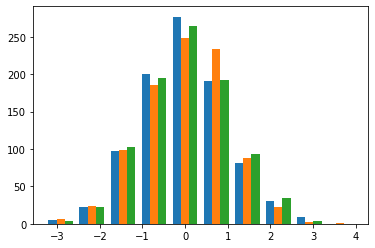

In [25]:
all_features.shape

(912, 515)

In [149]:
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler()
all_features_scaled = s_scaler.fit_transform(all_features)
colour_features_scaled = s_scaler.fit_transform(colour_features)
many_colour_features_scaled = s_scaler.fit_transform(many_colour_features)

(array([  5.,  31.,  66., 167., 232., 194., 141.,  60.,  11.,   5.]),
 array([-3.1089787 , -2.4678364 , -1.8266941 , -1.1855519 , -0.5444096 ,
         0.09673274,  0.73787504,  1.3790174 ,  2.0201597 ,  2.6613019 ,
         3.3024442 ], dtype=float32),
 <a list of 10 Patch objects>)

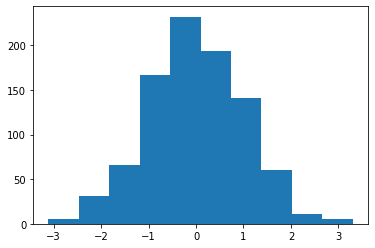

In [27]:
plt.hist(all_features_scaled[:, 3])

In [143]:
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def split_ponds_buildings(data):
  num_pcs = data.shape[-1]
  pca = PCA(num_pcs)
  pcs = pca.fit_transform(data)

  pcs_dict = {f'pc{i+1}': pcs[:, i] for i in range(num_pcs)}
  pcs_dict['artist'] = artist_list

  pcs_df = pd.DataFrame(pcs_dict)
  
  k_cluster = KMeans(2)
  k_cluster.fit(pcs)
  pcs_df['k_labels'] = k_cluster.labels_

  ponds_mask = pcs_df['k_labels'] == 1
  ponds = all_features_scaled[ponds_mask]

  buildings_mask = pcs_df['k_labels'] == 0
  buildings = all_features_scaled[buildings_mask]

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
  sns.scatterplot(data = pcs_df.sample(300), x = 'pc1', y = 'pc2', hue = 'artist', ax = ax1)
  ax1.set_title('Before Clustering - by artist')
  ax1.legend('')
  sns.scatterplot(data = pcs_df.sample(300), x = 'pc1', y = 'pc2', hue = 'k_labels', ax = ax2)
  ax2.set_title('After Kmeans Clustering')
  ax2.legend('')

  return ponds, ponds_mask, buildings, buildings_mask


In [92]:
colour_features_scaled.shape

(912, 3)

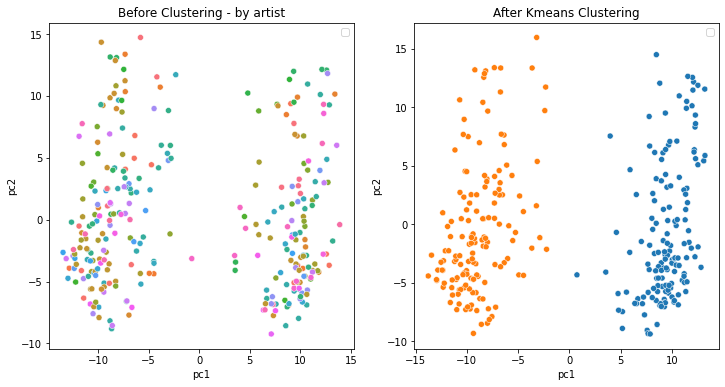

In [144]:
ponds, ponds_mask, buildings, buildings_mask = split_ponds_buildings(all_features_scaled)

In [150]:
colour_ponds = colour_features_scaled[ponds_mask]
colour_buildings = colour_features_scaled[buildings_mask]
many_colour_ponds = many_colour_features_scaled[ponds_mask]
many_colour_buildings = many_colour_features_scaled[buildings_mask]

In [151]:
# pca only ponds
from sklearn.decomposition import PCA
num_pcs = 2
pca = PCA(num_pcs)
pcs_ponds = pca.fit_transform(many_colour_ponds)

pcs_ponds_dict = {f'pc{i+1}': pcs_ponds[:, i] for i in range(num_pcs)}
pcs_ponds_dict['artist'] = np.array(artist_list)[ponds_mask]

pcs_ponds_df = pd.DataFrame(pcs_ponds_dict)

In [152]:
pcs_ponds_df

,pc1,pc2,artist
0,-2.918425,-0.857737,Copley_William
1,3.427509,1.573271,Copley_William
2,1.514531,-2.844429,Copley_William
3,0.643740,-0.995976,Arcimboldo_Giuseppe
4,-2.925049,-0.861233,Arcimboldo_Giuseppe
...,...,...,...
470,3.638766,0.688618,Emshwiller_Ed
471,-0.290700,-1.602867,Emshwiller_Ed
472,1.494433,-2.824353,Robert_Hubert
473,-0.856130,-0.133746,Robert_Hubert


In [ ]:
plt.plot(pca.explained_variance_ratio_)

In [ ]:
# pca only buildings
from sklearn.decomposition import PCA
num_pcs = 2
pca = PCA(num_pcs)
pcs_buildings = pca.fit_transform(many_colour_buildings)

pcs_buildings_dict = {f'pc{i+1}': pcs_buildings[:, i] for i in range(num_pcs)}
pcs_buildings_dict['artist'] = np.array(artist_list)[buildings_mask]

pcs_buildings_df = pd.DataFrame(pcs_buildings_dict)

In [ ]:
pcs_buildings_df

In [ ]:
plt.plot(pca.explained_variance_ratio_)

In [105]:
# tsne only ponds
from sklearn.manifold import TSNE

import pandas as pd
num_tsne = 2
tsne = TSNE(num_tsne, perplexity = 7.0)
tsne_ponds = tsne.fit_transform(ponds)

tsne_ponds_dict = {f'pc{i+1}': tsne_ponds[:, i] for i in range(num_tsne)}
tsne_ponds_dict['artist'] = np.array(artist_list)[ponds_mask]

tsne_ponds_df = pd.DataFrame(tsne_ponds_dict)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [67]:
# tsne only buildings
from sklearn.manifold import TSNE

import pandas as pd
num_tsne = 2
tsne = TSNE(num_tsne, perplexity = 7.0)
tsne_buildings = tsne.fit_transform(buildings)

tsne_buildings_dict = {f'pc{i+1}': tsne_buildings[:, i] for i in range(num_tsne)}
tsne_buildings_dict['artist'] = np.array(artist_list)[buildings_mask]

tsne_buildings_df = pd.DataFrame(tsne_buildings_dict)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [68]:
# import umap

# reducer = umap.UMAP()

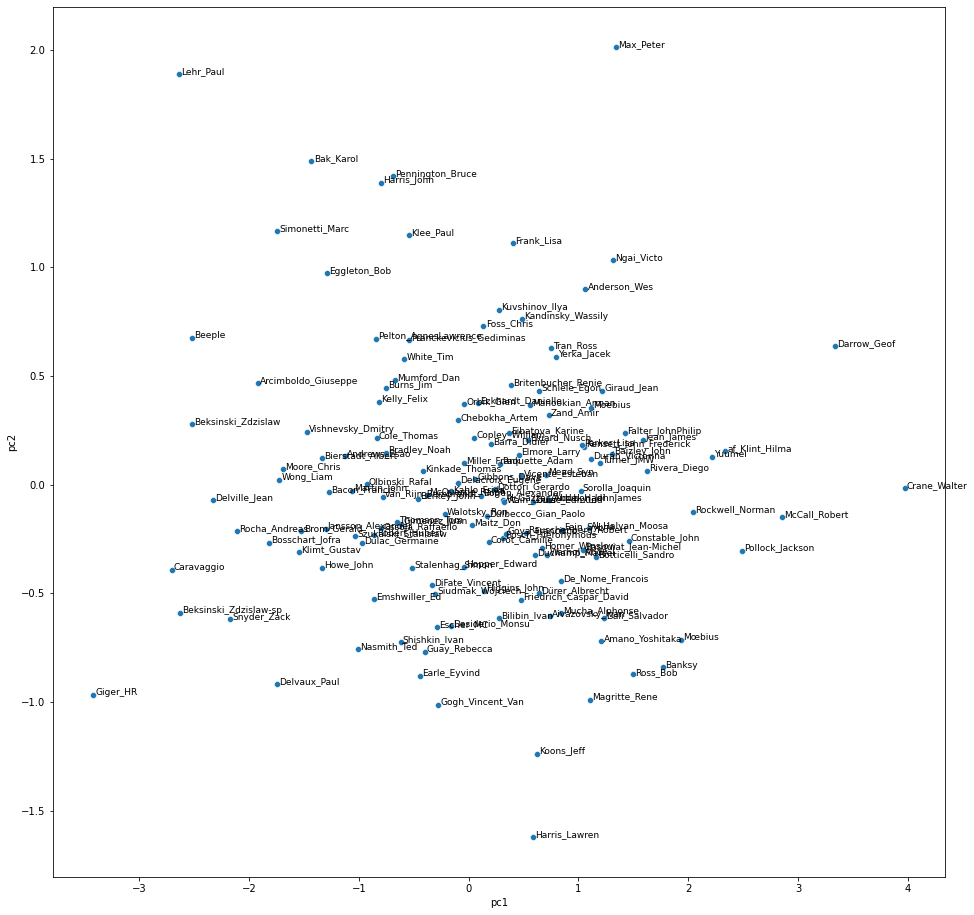

In [102]:
# create labelled scatterplot
artist_df = pcs_ponds_df.groupby(['artist']).mean().reset_index()

fig , ax = plt.subplots(figsize = (16, 16))
sns.scatterplot(data = artist_df, x = 'pc1', y = 'pc2', ax = ax)

for i, point in artist_df.iterrows():
        ax.text(point['pc1']+.02, point['pc2'], str(point['artist']), size = '9')

In [ ]:
#from tensorflow.keras.utils import array_to_img
#array_to_img(ponds_list[0]).resize((64, 64))

## plotting images onto pc coords

In [155]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tensorflow.image import resize


def show_xy_images(in_df, imgs, image_zoom=1):
    fig, ax1 = plt.subplots(1,1, figsize=(16, 16))
    artists = []
    for idx, c_row in tqdm(in_df.reset_index().iterrows()):
        #c_img = Image.open(c_row['path']).resize((64, 64))
        c_img = resize(img_to_array(imgs[idx]), [50,50]) / 255.0
        img = OffsetImage(c_img, zoom=image_zoom)
        ab = AnnotationBbox(img, (c_row['pc1'], c_row['pc2']), xycoords='data', frameon=False)
        artists.append(ax1.add_artist(ab))
    ax1.update_datalim(in_df[['pc1', 'pc2']])
    ax1.autoscale()
    #ax1.axis('off')
#show_xy_images(pcs_df[ponds], imgs = np.array(ponds_list, dtype=object)[ponds])

475it [00:03, 121.19it/s]


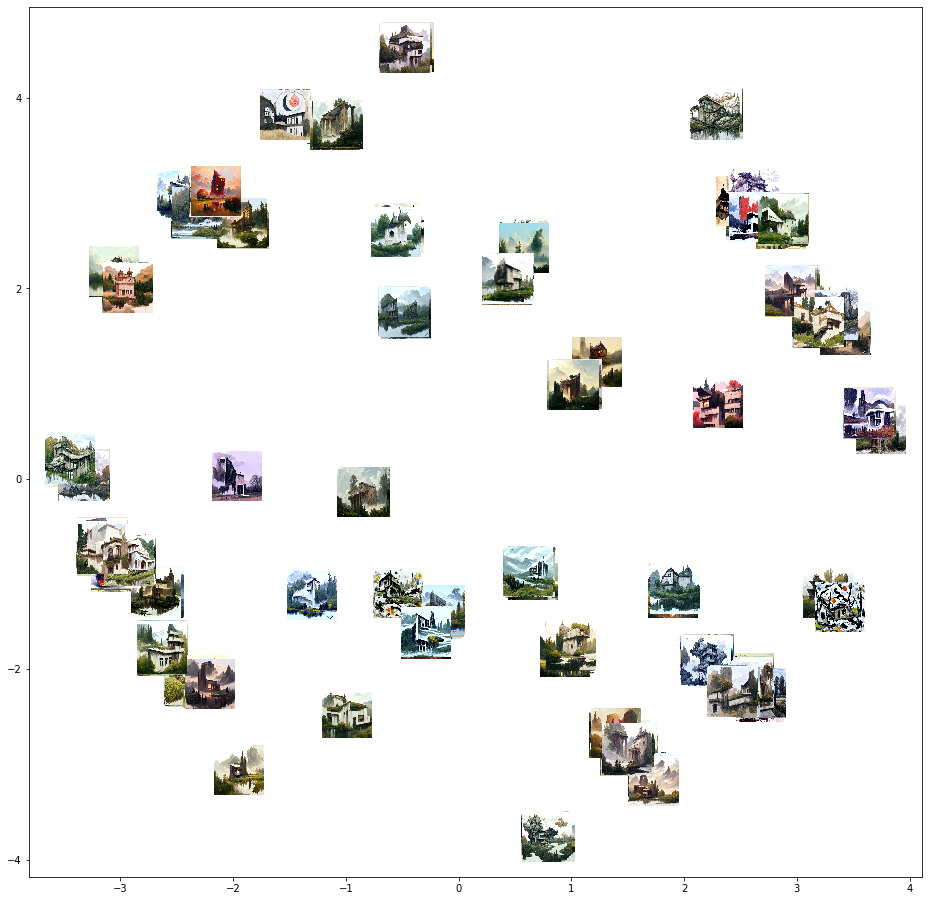

In [156]:
show_xy_images(pcs_ponds_df, imgs = art_list[ponds_mask])

475it [00:04, 110.78it/s]


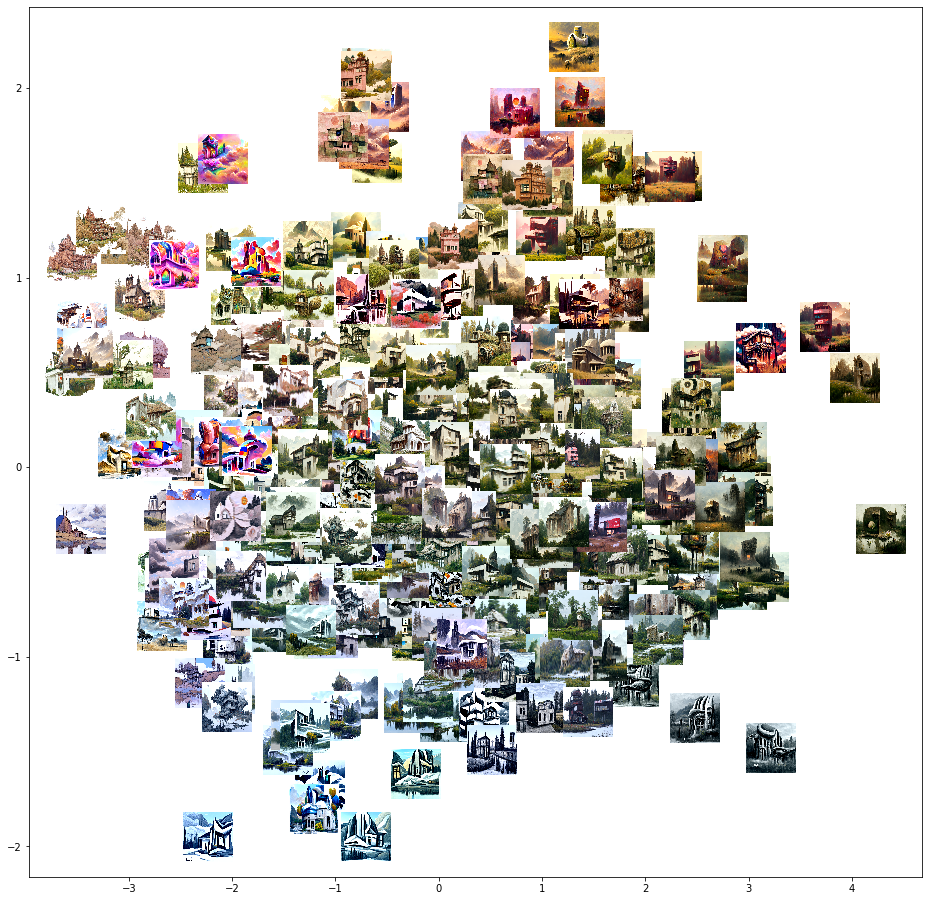

In [121]:
show_xy_images(pcs_buildings_df, imgs = art_list[buildings_mask])

437it [00:03, 123.81it/s]


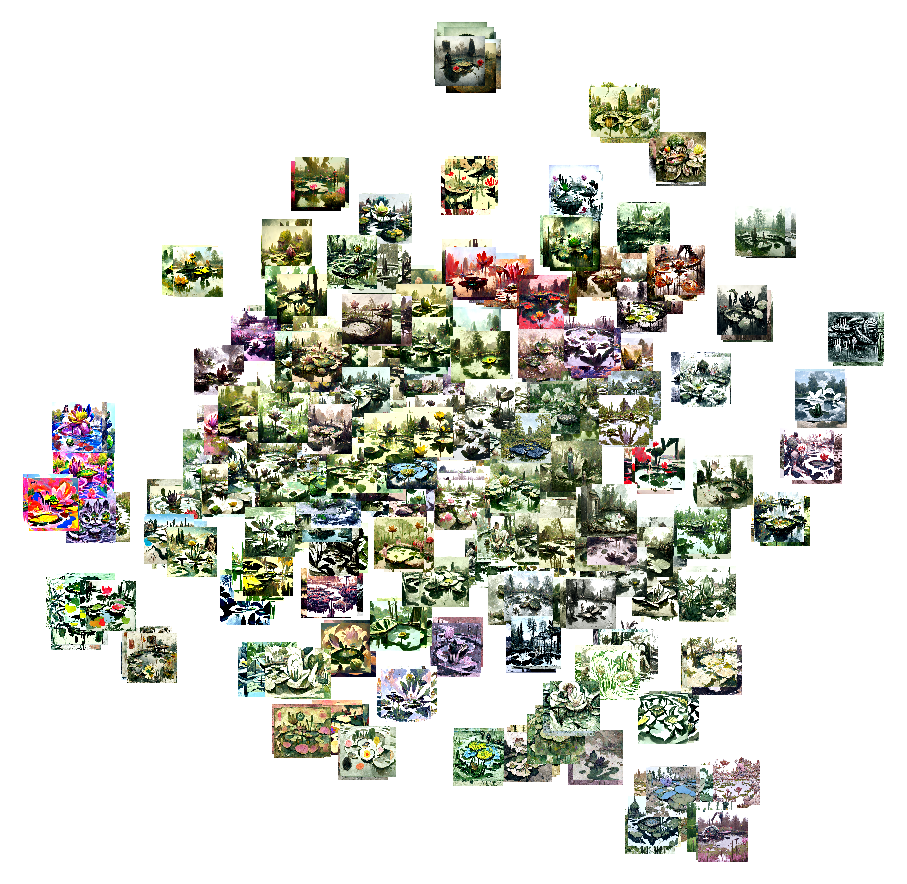

In [106]:
show_xy_images(tsne_ponds_df, imgs = art_list[ponds_mask])

In [ ]:
show_xy_images(tsne_buildings_df, imgs = art_list[buildings_mask])

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(np.array(ponds_list)[0].astype(int))

In [ ]:
# resize
# get features

In [ ]:
# just add pil images to a list, have a later funtion to convert them all to an array

In [ ]:
# preprocess data properly

In [ ]:
# prompts
artist = ""
pond = f'A beautiful painting of a waterlily pond, {artist}, Trending on artstation'
building = f'A beautiful painting of a building in a serene landscape, {artist}, Trending on artstation'

In [ ]:
# idea for showing the images
# https://www.kaggle.com/code/kmader/hurricane-damage-overview

In [ ]:
# def color_count_feature(in_path):
#     raw_image = Image.open(in_path) 
#     web_image = raw_image.convert('P', palette='WEB', dither=None)
#     counts, bins = np.histogram(np.array(web_image).ravel(), bins=np.arange(256))
#     return counts*1.0/np.prod(web_image.size) # normalize output

# image_df['color_features'] = image_df['path'].progress_map(color_count_feature)
